In [1]:
%matplotlib inline
from itertools import product as c_product
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn import linear_model

from disp import set_font_size
from lin_fit import fit_h


EXPT = 'CL_360_LOWFLOW_ACV_1'
# EXPT = 'CL_180_HighFlow_ACV'

TARGS = ['G2', 'G3', 'G4', 'G5']
SRCS = ['Odor', 'AbsHeading', 'ForVel']
NORMED_COLS = ['G2', 'G3', 'G4', 'G5', 'ForVel', 'AngVel', 'AbsAngVel', 'Heading', 'AbsHeading', 'Motion']

COLORS = {
    'G2': 'r', 'G3': 'c', 'G4': 'g', 'G5': 'm',
    'Motion': 'k', 'ForVel': 'k', 'AngVel': 'k',
}

T_WDW = [-4.5, 4.5]  # must be symmetric to ensure correct convolution
TRUNCATE = 5  # num timepoints to truncate for edge effects

DT = 0.1
T_WDW_TR = [DT * (int(T_WDW[0]/DT) + TRUNCATE), DT * (int(T_WDW[1]/DT) - TRUNCATE)]

DATA_DIR = os.path.join('data_heading_errors', EXPT)
SAVE_DIR = os.path.join('data_heading_errors', '_RESULTS', 'ODOR_TRACKING')
SAVE_DIR_STATS = os.path.join('data_heading_errors', '_RESULTS', 'ODOR_TRACKING_STATS')

if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)
    
if not os.path.exists(SAVE_DIR_STATS):
    os.makedirs(SAVE_DIR_STATS)

# Load data and normalize

In [2]:
base = 'clean.csv'
mvng = 'moving.csv'
mvng_cols = ['Start', 'Stop']
odor = 'odor_times.csv'
odor_cols = ['Odor_On', 'Odor_Off', 'Include']

trials = []
data_u = {}  # unnormalized data
data_n = {}  # normalized data
d_mvng = {}  # dfs of moving times
d_odor = {}  # dfs of odor times

for fly in os.listdir(DATA_DIR):
    fly_path = os.path.join(DATA_DIR, fly)
    
    for trial in os.listdir(fly_path):
        trial_path = os.path.join(fly_path, trial)
        
        # load data
        data_u_ = pd.read_csv(os.path.join(trial_path, base))
        
        # store relevant columns
        data_u_ = data_u_[['Time', 'G2_avg', 'G3_avg', 'G4_avg', 'G5_avg', 'ForVel', 'AngVel', 'Heading', 'Motion']]
        data_u_['AbsAngVel'] = np.abs(data_u_['AngVel'])
        data_u_['AbsHeading'] = np.abs(data_u_['Heading'])
        
        # make odor mask
        df_odor = pd.read_csv(os.path.join(trial_path, odor))
        odor_mask = np.zeros(len(data_u_['Time']), dtype=bool)
        starts = df_odor[odor_cols[0]]
        stops = df_odor[odor_cols[1]]
        
        for start, stop in zip(starts, stops):
            odor_mask[(start <= data_u_['Time']) & (data_u_['Time'] < stop)] = True
            
        data_u_['Odor'] = odor_mask.astype(float)
        
        # make moving mask
        df_mvng = pd.read_csv(os.path.join(trial_path, mvng))
        mvng_mask = np.zeros(len(data_u_['Time']), dtype=bool)
        starts = df_mvng[mvng_cols[0]]
        stops = df_mvng[mvng_cols[1]]
        
        for start, stop in zip(starts, stops):
            mvng_mask[(start <= data_u_['Time']) & (data_u_['Time'] < stop)] = True
            
        data_u_['Mvng'] = mvng_mask
        
        data_u_ = data_u_.rename(columns={'G2_avg': 'G2', 'G3_avg': 'G3', 'G4_avg': 'G4', 'G5_avg': 'G5'})
        
        # normalize data
        data_n_ = data_u_.copy()
        data_n_[NORMED_COLS] -= data_n_[NORMED_COLS].mean()
        data_n_[NORMED_COLS] /= data_n_[NORMED_COLS].std()
        
        # store all results
        data_u[trial] = data_u_
        data_n[trial] = data_n_
        d_mvng[trial] = df_mvng
        d_odor[trial] = df_odor
        
        trials.append(trial)

# Plot trial example

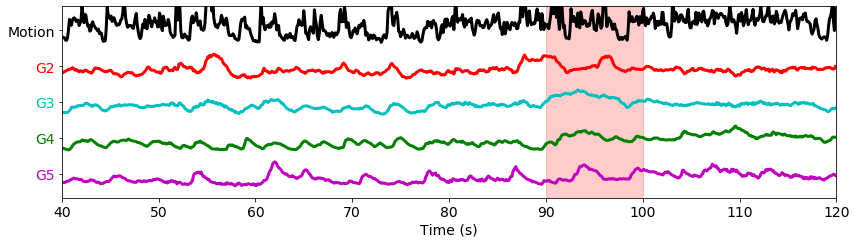

In [3]:
fig_size = (12, 3.5)
font_size = 14
trial = trials[25]
t_wdw = (40, 120)
vs = ['G2', 'G3', 'G4', 'G5']

fig, ax = plt.subplots(1, 1, figsize=fig_size, tight_layout=True)

t = data_n[trial]['Time']
t_mask = (t_wdw[0] <= t) & (t < t_wdw[1])

motion = data_n[trial]['Motion'][t_mask]
motion -= motion.min()
motion /= (.3 * motion.max())

ax.plot(t[t_mask], motion - 1.5, lw=3, c='k')

offsets = [-1.5]

for v_ctr, v in enumerate(vs):
    x = data_n[trial][v][t_mask]
    x -= x.min()
    x /= x.max()
    
    offset = -(v_ctr + 2)*1.5
    ax.plot(t[t_mask], x + offset, lw=3, c=COLORS[v])

    offsets.append(offset)
    
offsets = np.array(offsets)

df_odor = d_odor[trial]

for r_ctr, r in df_odor.iterrows():
    start = r['Odor_On']
    stop = r['Odor_Off']
    ax.axvspan(start, stop, color='r', alpha=0.2)

ax.set_xlim(t_wdw)
ax.set_ylim(-8, 0)
ax.set_yticks(offsets + 0.5)
ax.set_yticklabels(['Motion'] + vs)

for y_tick, v in zip(ax.get_yticklabels(), ['Motion'] + vs):
    y_tick.set_color(COLORS[v])

ax.set_xlabel('Time (s)')

set_font_size(ax, font_size)

# Table of odor-triggered metrics

In [4]:
WDW_G = (1, 4)

def calc_metrics(trial, data, pulse, mvmt, ctl_offset):
    """Calculate metrics for each odor pulse."""
    
    p_on = pulse['Odor_On'] + ctl_offset
    p_off = pulse['Odor_Off'] + ctl_offset
    
    rslt = {}
    
    rslt['Trial'] = trial
    rslt['On'] = p_on
    rslt['Off'] = p_off
    rslt['Include'] = 'Include' if pulse['Include'] else 'Exclude'
    
    # Preliminary
    t = np.array(data['Time'])
    
    ## mvmt times
    mvng = np.zeros(len(t), dtype=bool)
    
    for m_ctr in range(len(mvmt)):
        mvmt_bout = mvmt.iloc[m_ctr]
        
        t_mask = (mvmt_bout['Start'] <= t) & (t < mvmt_bout['Stop'])
        mvng[t_mask] = True
        
        del t_mask
    
    # compute all metrics
    
    for gx in ['G2', 'G3', 'G4', 'G5']:
        ###### METRIC ######
        # GX t-avg'd from 10 to 0 s pre odor onset
        t_mask_0 = (p_on-10 <= t) & (t < p_on)
        rslt['{}_neg10_0'.format(gx)] = np.nanmean(np.array(data[gx][t_mask_0]))

        del t_mask_0

        ###### METRIC ######
        # dF/F GX t-avg'd from 1 to 4 s post odor onset
        t_mask = (p_on+WDW_G[0] <= t) & (t < p_on+WDW_G[1])
        rslt['d_{}_{}_{}'.format(gx, *WDW_G)] = \
            (np.nanmean(np.array(data[gx])[t_mask]) - rslt['{}_neg10_0'.format(gx)]) / rslt['{}_neg10_0'.format(gx)]

        del t_mask
    
    ###### METRIC ######
    # abs heading t-avg'd from 10 to 0 s pre odor onset
    t_mask_0 = (p_on-10 <= t) & (t < p_on)
    rslt['h_neg10_0'] = np.nanmean(np.abs(data['Heading'][t_mask_0]))
    
    del t_mask_0
    
    ###### METRIC ######
    # change in abs heading from h_neg10_0, t-avgd from 1 to 4 s post odor onset
    t_mask = (p_on+1 <= t) & (t < p_on+4)
    rslt['d_h_1_4'] = np.nanmean(np.abs(data['Heading'][t_mask])) - rslt['h_neg10_0']
    
    del t_mask
    
    ###### METRIC ######
    # change in abs heading from h_neg10_0, t-avgd from 7 to 10 s post odor onset 
    t_mask = (p_on+7 <= t) & (t < p_on+10)
    rslt['d_h_7_10'] = np.nanmean(np.abs(data['Heading'][t_mask])) - rslt['h_neg10_0']
    
    del t_mask
    
    ###### METRIC ######
    # forward velocity t-avgd from 10 to 0 s pre odor onset
    t_mask_0 = (p_on-10 <= t) & (t < p_on)
    rslt['v_neg10_0'] = np.nanmean(data['ForVel'][t_mask_0])
    
    del t_mask_0
    
    ##### METRIC #####
    # change in forward velocity from v_neg10_0, t-avgd 1 to 4 s after odor onset
    t_mask = (p_on+1 <= t) & (t < p_on+4)
    rslt['d_v_1_4'] = np.nanmean(data['ForVel'][t_mask]) - rslt['v_neg10_0']
    
    del t_mask
    
    ##### METRIC #####
    # change in forward velocity from v_neg10_0, t-avgd 7 to 10 s after odor onset
    t_mask = (p_on+7 <= t) & (t < p_on+10)
    rslt['d_v_7_10'] = np.nanmean(data['ForVel'][t_mask]) - rslt['v_neg10_0']
    
    del t_mask
    
    # MVNG ONLY METRICS
    
    for gx in ['G2', 'G3', 'G4', 'G5']:
        ###### METRIC ######
        # MVNG ONLY GX t-avg'd from 10 to 0 s pre odor onset
        t_mask_0 = (p_on-10 <= t) & (t < p_on) & mvng
        rslt['{}_neg10_0_mv'.format(gx)] = np.nanmean(np.array(data[gx][t_mask_0]))

        del t_mask_0

        ###### METRIC ######
        # MVNG ONLY dF/F GX t-avg'd from 1 to 4 s post odor onset
        t_mask = (p_on+WDW_G[0] <= t) & (t < p_on+WDW_G[1]) & mvng
        rslt['d_{}_{}_{}_mv'.format(gx, *WDW_G)] = \
            (np.nanmean(np.array(data[gx])[t_mask]) - rslt['{}_neg10_0'.format(gx)]) / rslt['{}_neg10_0'.format(gx)]

        del t_mask
    
    ###### METRIC ######
    # MVNG ONLY abs heading t-avg'd from 10 to 0 s pre odor onset
    t_mask_0 = (p_on-10 <= t) & (t < p_on) & mvng
    rslt['h_neg10_0_mv'] = np.nanmean(np.abs(data['Heading'][t_mask_0]))
    
    del t_mask_0
    
    ###### METRIC ######
    # MVNG ONLY change in abs heading from h_neg10_0, t-avgd from 1 to 4 s post odor onset
    t_mask = (p_on+1 <= t) & (t < p_on+4) & mvng
    rslt['d_h_1_4_mv'] = np.nanmean(np.abs(data['Heading'][t_mask])) - rslt['h_neg10_0']
    
    del t_mask
    
    ###### METRIC ######
    # MVNG ONLY change in abs heading from h_neg10_0, t-avgd from 7 to 10 s post odor onset 
    t_mask = (p_on+7 <= t) & (t < p_on+10) & mvng
    rslt['d_h_7_10_mv'] = np.nanmean(np.abs(data['Heading'][t_mask])) - rslt['h_neg10_0']
    
    del t_mask
    
    ###### METRIC ######
    # MVNG ONLY forward velocity t-avgd from 10 to 0 s pre odor onset
    t_mask_0 = (p_on-10 <= t) & (t < p_on) & mvng
    rslt['v_neg10_0_mv'] = np.nanmean(data['ForVel'][t_mask_0])
    
    del t_mask_0
    
    ##### METRIC #####
    # MVNG ONLY change in forward velocity from v_neg10_0, t-avgd 1 to 4 s after odor onset
    t_mask = (p_on+1 <= t) & (t < p_on+4) & mvng
    rslt['d_v_1_4_mv'] = np.nanmean(data['ForVel'][t_mask]) - rslt['v_neg10_0']
    
    del t_mask
    
    ##### METRIC #####
    # MVNG ONLY change in forward velocity from v_neg10_0, t-avgd 7 to 10 s after odor onset
    t_mask = (p_on+7 <= t) & (t < p_on+10) & mvng
    rslt['d_v_7_10_mv'] = np.nanmean(data['ForVel'][t_mask]) - rslt['v_neg10_0']
    
    del t_mask
    
    return rslt

In [5]:
for ctl_offset in [0, -10, -20, -30]:
    metrics_dicts = []

    for trial, data_u_ in data_u.items():

        odor = d_odor[trial]
        mvmt = d_mvng[trial]

        # loop over odor pulses
        for p_ctr in range(len(odor)):
            pulse = odor.iloc[p_ctr]

            metrics_dicts.append(calc_metrics(trial, data_u_, pulse, mvmt, ctl_offset=ctl_offset))

    metrics = pd.DataFrame.from_records(metrics_dicts)
    metrics.index.name = 'Pulse'

    # re-order columns
    cols = list(metrics.columns)
    cols = [cols.pop(cols.index(col)) for col in ['Trial', 'On', 'Off', 'Include']] + cols
    metrics = metrics[cols]

    # add control vars to test stats analysis
    x_c_1, x_c_2, x_c_3, x_c_4 = np.random.normal(0, 1, (4, len(metrics)))
    y_c = x_c_1 + x_c_2 + x_c_3 + np.random.normal(0, 1, len(metrics))

    metrics['x_c_1'] = x_c_1
    metrics['x_c_2'] = x_c_2
    metrics['x_c_3'] = x_c_3
    metrics['x_c_4'] = x_c_4
    metrics['y_c'] = y_c

    if not ctl_offset:
        metrics.to_csv(os.path.join(SAVE_DIR, '{}_METRICS.csv'.format(EXPT)))
    else:
        metrics.to_csv(os.path.join(SAVE_DIR, '{}_METRICS_FALSE_ODOR_OFFSET_{}.csv'.format(EXPT, ctl_offset)))

/home/z051m/miniconda3/envs/sci/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: Mean of empty slice
/home/z051m/miniconda3/envs/sci/lib/python3.6/site-packages/ipykernel_launcher.py:118: RuntimeWarning: Mean of empty slice
/home/z051m/miniconda3/envs/sci/lib/python3.6/site-packages/ipykernel_launcher.py:139: RuntimeWarning: Mean of empty slice
/home/z051m/miniconda3/envs/sci/lib/python3.6/site-packages/ipykernel_launcher.py:125: RuntimeWarning: Mean of empty slice
/home/z051m/miniconda3/envs/sci/lib/python3.6/site-packages/ipykernel_launcher.py:146: RuntimeWarning: Mean of empty slice
/home/z051m/miniconda3/envs/sci/lib/python3.6/site-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/home/z051m/miniconda3/envs/sci/lib/python3.6/site-packages/ipykernel_launcher.py:111: RuntimeWarning: Mean of empty slice
/home/z051m/miniconda3/envs/sci/lib/python3.6/site-packages/ipykernel_launcher.py:132: RuntimeWarning: Mean of empty slice


# Sanity checks

/home/z051m/miniconda3/envs/sci/lib/python3.6/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  del sys.path[0]


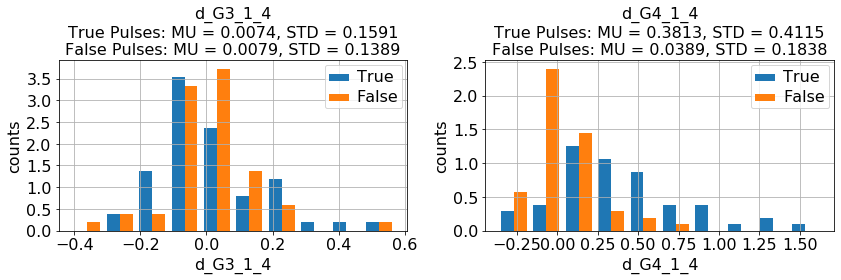

In [6]:
# distribution of G3 and G4 responses to odor
metrics = pd.read_csv(os.path.join(SAVE_DIR, '{}_METRICS.csv'.format(EXPT)), index_col=0)
metrics_ctls = {}

for ctl_offset in [-10, -20, -30]:
    metrics_ctls[ctl_offset] = pd.read_csv(
        os.path.join(SAVE_DIR, '{}_METRICS_FALSE_ODOR_OFFSET_{}.csv'.format(EXPT, ctl_offset)), index_col=0)

fig, axs = plt.subplots(1, 2, figsize=(12, 4), tight_layout=True)

for ax, k in zip(axs, ['d_G3_1_4', 'd_G4_1_4']):
    
    ax.hist(np.array([metrics[k], metrics_ctls[-10][k]]).T, normed=True)
    ax.set_xlabel(k)
    ax.set_ylabel('counts')
    ax.set_title('{4}\nTrue Pulses: MU = {0:.4f}, STD = {1:.4f}\nFalse Pulses: MU = {2:.4f}, STD = {3:.4f}'.format(
        np.nanmean(metrics[k]), np.nanstd(metrics[k]),
        np.nanmean(metrics_ctls[-10][k]), np.nanstd(metrics_ctls[-10][k]), k))
    ax.legend(['True', 'False'])


for ax in axs:
    ax.grid()
    set_font_size(ax, 16)

# Nested model analysis

Explaining neural.

In [7]:
FACTORS = ['None', 'h_neg10_0', 'd_h_1_4', 'd_v_1_4', 'd_v_7_10', 'd_h_7_10']

In [8]:
for ctl_offset in [0, -10, -20, -30]:

    if not ctl_offset:
        metrics_filt = metrics[metrics['Include'] == 'Include'].dropna()
    else:
        metrics_filt = metrics_ctls[ctl_offset][metrics_ctls[ctl_offset]['Include'] == 'Include'].dropna()
        
    for gx in ['G2', 'G3', 'G4', 'G5']:

        print('{}:'.format(gx))

        targ = 'd_{}_1_4'.format(gx)
        y = metrics_filt[targ]

        # reduced factors
        factors_r = []

        # track residual variances, f-vals, and p-vals
        res_vars = [np.nanvar(y)]
        fs = [np.nan]
        ps = [np.nan]

        for ctr, factor in enumerate(FACTORS[1:]):

            # fit reduced model
            if ctr == 0:
                y_hat_r = np.nanmean(y)
            else:
                xs_r = metrics_filt[factors_r]
                rgr_r = linear_model.LinearRegression().fit(xs_r, y)
                y_hat_r = rgr_r.predict(xs_r)

            # fit full model
            factors_f = factors_r + [factor]
            xs_f = metrics_filt[factors_f]
            rgr_f = linear_model.LinearRegression().fit(xs_f, y)
            y_hat_f = rgr_f.predict(xs_f)

            print('CTR = {}'.format(ctr))
            print('FACTORS_R = {}'.format(factors_r))
            print('FACTORS_F = {}'.format(factors_f))

            # calc variance of residual 
            res_var = np.nanvar(y - y_hat_f)
            res_vars.append(res_var)

            # calc f & p val btwn reduced and full
            n = len(y)

            rss_r = np.sum((y - y_hat_r)**2)
            rss_f = np.sum((y - y_hat_f)**2)

            # params
            p_r = ctr + 1
            p_f = ctr + 2

            # degs freedom
            dfn = p_f - p_r
            dfd = n - p_f

            # compute F
            f = ((rss_r - rss_f) / (p_f - p_r)) / (rss_f / (n - p_f))

            # compute p_val
            p = stats.f.sf(f, dfn, dfd)

            fs.append(f)
            ps.append(p)

            # make current full factor set be next reduced factor set
            factors_r = factors_f

        print('P = {}'.format(ps))

        df_save = pd.DataFrame(
            data={'FACTORS': FACTORS, 'RES_VAR': res_vars, 'F': fs, 'P': ps},
            columns=['FACTORS', 'RES_VAR', 'F', 'P'])

        if not ctl_offset:
            fn = '{}_{}_FROM_NESTED.csv'.format(EXPT, targ)
        else:
            fn = '{}_{}_FROM_NESTED_FALSE_ODOR_OFFSET_{}.csv'.format(EXPT, targ, ctl_offset)
            
        df_save.to_csv(os.path.join(SAVE_DIR_STATS, fn), index=False, na_rep='NaN')

G2:
CTR = 0
FACTORS_R = []
FACTORS_F = ['h_neg10_0']
CTR = 1
FACTORS_R = ['h_neg10_0']
FACTORS_F = ['h_neg10_0', 'd_h_1_4']
CTR = 2
FACTORS_R = ['h_neg10_0', 'd_h_1_4']
FACTORS_F = ['h_neg10_0', 'd_h_1_4', 'd_v_1_4']
CTR = 3
FACTORS_R = ['h_neg10_0', 'd_h_1_4', 'd_v_1_4']
FACTORS_F = ['h_neg10_0', 'd_h_1_4', 'd_v_1_4', 'd_v_7_10']
CTR = 4
FACTORS_R = ['h_neg10_0', 'd_h_1_4', 'd_v_1_4', 'd_v_7_10']
FACTORS_F = ['h_neg10_0', 'd_h_1_4', 'd_v_1_4', 'd_v_7_10', 'd_h_7_10']
P = [nan, 0.7192291676959665, 0.228737673817693, 4.4251165075329146e-05, 0.6846617661041863, 0.8685563123049667]
G3:
CTR = 0
FACTORS_R = []
FACTORS_F = ['h_neg10_0']
CTR = 1
FACTORS_R = ['h_neg10_0']
FACTORS_F = ['h_neg10_0', 'd_h_1_4']
CTR = 2
FACTORS_R = ['h_neg10_0', 'd_h_1_4']
FACTORS_F = ['h_neg10_0', 'd_h_1_4', 'd_v_1_4']
CTR = 3
FACTORS_R = ['h_neg10_0', 'd_h_1_4', 'd_v_1_4']
FACTORS_F = ['h_neg10_0', 'd_h_1_4', 'd_v_1_4', 'd_v_7_10']
CTR = 4
FACTORS_R = ['h_neg10_0', 'd_h_1_4', 'd_v_1_4', 'd_v_7_10']
FACTORS_F = [

CTR = 0
FACTORS_R = []
FACTORS_F = ['h_neg10_0']
CTR = 1
FACTORS_R = ['h_neg10_0']
FACTORS_F = ['h_neg10_0', 'd_h_1_4']
CTR = 2
FACTORS_R = ['h_neg10_0', 'd_h_1_4']
FACTORS_F = ['h_neg10_0', 'd_h_1_4', 'd_v_1_4']
CTR = 3
FACTORS_R = ['h_neg10_0', 'd_h_1_4', 'd_v_1_4']
FACTORS_F = ['h_neg10_0', 'd_h_1_4', 'd_v_1_4', 'd_v_7_10']
CTR = 4
FACTORS_R = ['h_neg10_0', 'd_h_1_4', 'd_v_1_4', 'd_v_7_10']
FACTORS_F = ['h_neg10_0', 'd_h_1_4', 'd_v_1_4', 'd_v_7_10', 'd_h_7_10']
P = [nan, 0.3985783677522319, 0.49529776659337665, 0.0027944161073839447, 0.7718216890857926, 0.07969603972620319]


## Make plots

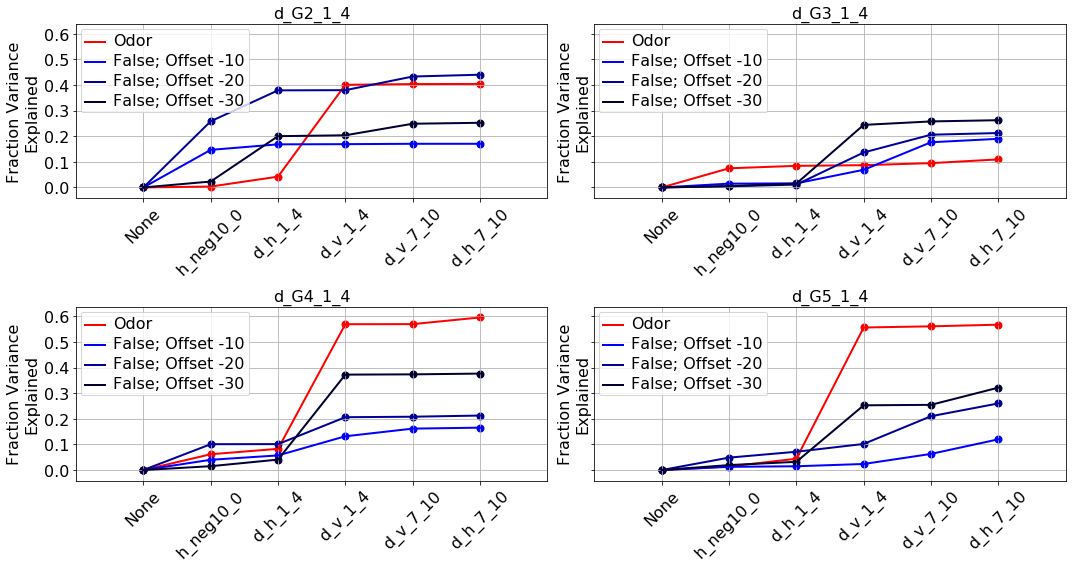

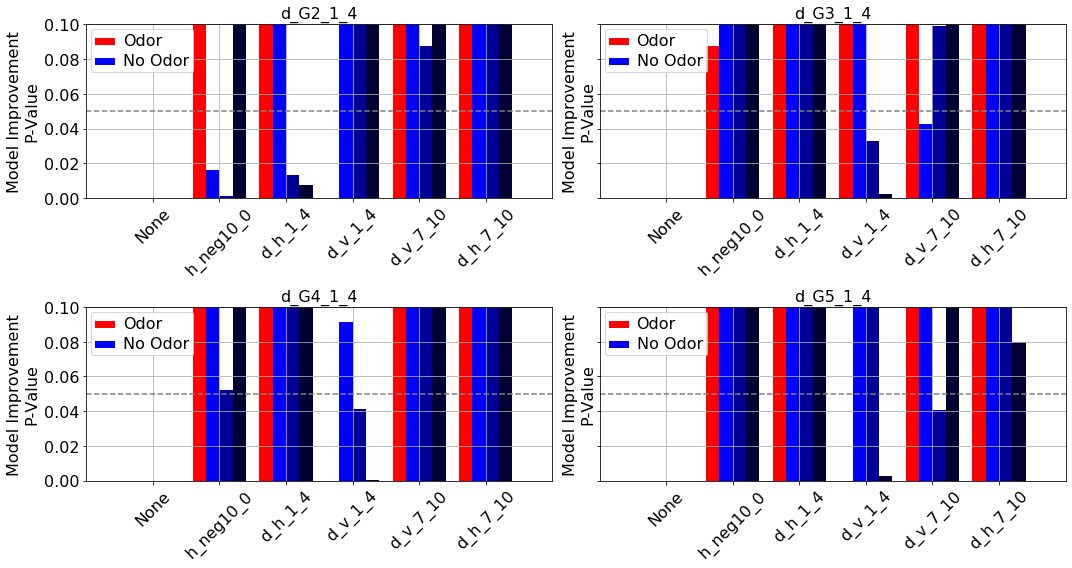

In [9]:
ctl_colors = {-10: (0, 0, 1), -20: (0, 0, .6), -30: (0, 0, .2)}
x_lim = (-1, 6)

fig, axs = plt.subplots(2, 2, figsize=(15, 8), tight_layout=True, sharey=True)
fig_p, axs_p = plt.subplots(2, 2, figsize=(15, 8), tight_layout=True, sharey=True)


for ax, ax_p, gx in zip(axs.flat, axs_p.flat, ['G2', 'G3', 'G4', 'G5']):
    targ = 'd_{}_1_4'.format(gx)
    
    # explained variance
    
    ## true
    df = pd.read_csv(os.path.join(SAVE_DIR_STATS, '{}_{}_FROM_NESTED.csv'.format(EXPT, targ)))
    
    ## control
    df_ctls = {}
    for ctl_offset in [-10, -20, -30]:
        df_ctls[ctl_offset] = pd.read_csv(
            os.path.join(SAVE_DIR_STATS, '{}_{}_FROM_NESTED_FALSE_ODOR_OFFSET_{}.csv'.format(EXPT, targ, ctl_offset)))
    
    var = df['RES_VAR']
    var = (1 - var/var.max())
    
    # true
    ax.plot(np.arange(len(df)), var, color='r', lw=2)
    ax.scatter(np.arange(len(df)), var, color='r', lw=2)
    
    # controls
    for ctl_offset in [-10, -20, -30]:
        var_ctl = df_ctls[ctl_offset]['RES_VAR']
        var_ctl = (1 - var_ctl/var_ctl.max())
        
        ax.plot(np.arange(len(df)), var_ctl, color=ctl_colors[ctl_offset], lw=2)
        ax.scatter(np.arange(len(df)), var_ctl, color=ctl_colors[ctl_offset], lw=2)
    
    ax.set_xlim(x_lim)
    
    ax.set_xticks(np.arange(len(df)))
    ax.set_xticklabels(df['FACTORS'], rotation=45)
    
    ax.set_ylabel('Fraction Variance\nExplained')
    ax.set_title(targ)
    
    ax.legend(['Odor'] + ['False; Offset {}'.format(ctl_offset) for ctl_offset in [-10, -20, -30]], loc='upper left')
    
    ax.grid()
    set_font_size(ax, 16)
    
    # p-vals
    for co_ctr, ctl_offset in enumerate([-10, -20, -30]):
        x_offset = co_ctr * .2
        
        ax_p.bar(
            np.arange(len(df)) - .4, df['P'], align='edge', width=.2, color='r', lw=2)
        ax_p.bar(
            np.arange(len(df)) - .2 + x_offset, df_ctls[ctl_offset]['P'],
            align='edge', width=.2, color=ctl_colors[ctl_offset], lw=2)
        
    ax_p.legend(['Odor', 'No Odor'], loc='upper left')
    
    ax_p.axhline(0.05, color='gray', ls='--')
    
    ax_p.set_xlim(x_lim)
    ax_p.set_ylim(0, 0.1)
    
    ax_p.set_xticks(np.arange(len(df)))
    ax_p.set_xticklabels(df['FACTORS'], rotation=45)
    
    ax_p.set_ylabel('Model Improvement\nP-Value')
    ax_p.set_title(targ)
    
    ax_p.grid()
    set_font_size(ax_p, 16)
    
fig.savefig(os.path.join(SAVE_DIR_STATS, '{}_GX_FROM_NESTED.pdf'.format(EXPT)))
fig_p.savefig(os.path.join(SAVE_DIR_STATS, '{}_GX_FROM_NESTED_P.pdf'.format(EXPT)))